In [1]:
import torch
import torch.nn as nn
import torch.optim as optim

In [2]:
import pickle
cifar2 = pickle.load(open("cifar2.p", "rb"))
cifar2_val = pickle.load(open("cifar2_val.p", "rb"))

## Convolutions
Example: We have a 3 x 3 kernel stored as a tensor. The weight matrix will be 3 x 3 x 3 as we have a multichannel image (3 channels, one for R, G, and B). The same kernel is used throughout the whole image, as we want to pay attention to the same relative position of input and output pixels. So, the derivative of the loss w.r.t a convolution weight includes contributions from the whole image.

Note that now the number of parameters depends on the size of the convolution kernel and the number of filter used, not the whole image.

We will use 2D convolutions with the same size kernel across all dimensions of the image (as they all have the same size).

In [3]:
# 3 input per pixel, 16 channels in the output meaning 16 different feature maps, 
# each defined by a different set of shared weights
conv = nn.Conv2d(3, 16, kernel_size=3) 
conv

Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1))

In [4]:
conv.weight.shape, conv.bias.shape

(torch.Size([16, 3, 3, 3]), torch.Size([16]))

The above is because we have 16 different kernels, each 3 x 3 x 3 (one 3 x 3 kernel for each input channel)

Now use the model (note the weights will be initialized randomly)

In [5]:
img, _ = cifar2[0]
output = conv(img.unsqueeze(0)) # need to add a dimension at beginning because function takes B x C x H x W and we only have one image so B = 1
img.unsqueeze(0).shape, output.shape

(torch.Size([1, 3, 32, 32]), torch.Size([1, 16, 30, 30]))

Display output for fun

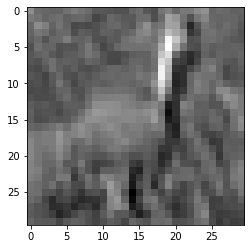

In [6]:
import matplotlib.pyplot as plt
plt.imshow(output[0, 0].detach(), cmap='gray')
plt.show()

The output image has smaller dimensions than inputs because when applying the convolutional kernels, we only consider when every pixel has a neighbor. We can change this by adding a padding of ghost zeros around the image. Use padding when we want tensors to be of comparable size after a few convolutions.

In [7]:
conv = nn.Conv2d(3, 1, kernel_size=3, padding=1)
output = conv(img.unsqueeze(0))
img.unsqueeze(0).shape, output.shape

(torch.Size([1, 3, 32, 32]), torch.Size([1, 1, 32, 32]))

Setting weights & bias by hand

In [8]:
with torch.no_grad():
    conv.bias.zero_()

with torch.no_grad():
    conv.weight.fill_(1.0 / 9.0) # avg of pixel values

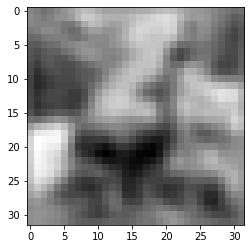

In [9]:
output = conv(img.unsqueeze(0))
plt.imshow(output[0, 0].detach(), cmap='gray')
plt.show()

Use an edge-detection kernel--measures difference in intensity between left and right pixels.

In [10]:
conv = nn.Conv2d(3, 1, kernel_size=3, padding=1)

with torch.no_grad():
    conv.weight[:] = torch.tensor([[-1.0, 0.0, 1.0],
                                   [-1.0, 0.0, 1.0],
                                   [-1.0, 0.0, 1.0]])
    conv.bias.zero_()

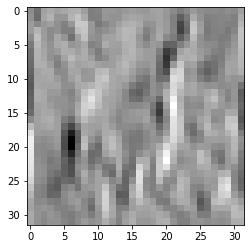

In [11]:
output = conv(img.unsqueeze(0))
plt.imshow(output[0, 0].detach(), cmap='gray')
plt.show()

Even though kernels are useful, we still need to consider the big picture. Use downsampling to accomplish this.

Some different downsampling methods:
- Average pooling
- Max pooling (popular but discards all but 1 pixel)
- Strided convolution (every Nth pixel calculated)

When features are found corresponding to the estimated kernel, they tend to have high magnitude. So, max pooling will keep these features.

In [12]:
pool = nn.MaxPool2d(2) # 2 is neighborhood over which to operate the pooling operation
output = pool(img.unsqueeze(0))
img.unsqueeze(0).shape, output.shape

(torch.Size([1, 3, 32, 32]), torch.Size([1, 3, 16, 16]))

Intuition of using pooling with convolutions: first set of kernels operates on small neighborhoods while second set of kernels (applied after pooling) operates on wider neighborhoods, providing features that are compositons of previous features.

Combining it together.

In [13]:
model = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, padding=1), # output is 16 channel
            nn.Tanh(),
            nn.MaxPool2d(2), # 16 x 32 x 32 pooled down to 16 x 16 x 16
            nn.Conv2d(16, 8, kernel_size=3, padding=1), # output is 8 channel
            nn.Tanh(),
            nn.MaxPool2d(2), # 8 x 8 x 8
            # WARNING: to get this to work, need to reshape the above layer to fit as below
            nn.Linear(8 * 8 * 8, 32), # 'flattens' the prev output into a 1D vector
            nn.Tanh(),
            nn.Linear(32, 2))

In [14]:
numel_list = [p.numel() for p in model.parameters()]
sum(numel_list), numel_list

(18090, [432, 16, 1152, 8, 16384, 32, 64, 2])

In [18]:
model(img.unsqueeze(0))

RuntimeError: mat1 and mat2 shapes cannot be multiplied (64x8 and 512x32)

Need to reshape the output of our last pooling layer before we can input it into the linear layer.

## Subclassing nn.Module
Need to define a forward function. Define submodules in the constructor.

In [15]:
class Net(nn.Module):
    def __init__(self):
        super().__init__() # always need
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.act1 = nn.Tanh()
        self.pool1 = nn.MaxPool2d(2)
        self.conv2 = nn.Conv2d(16, 8, kernel_size=3, padding=1)
        self.act2 = nn.Tanh()
        self.pool2 = nn.MaxPool2d(2)
        self.fc1 = nn.Linear(8 * 8 * 8, 32)
        self.act3 = nn.Tanh()
        self.fc2 = nn.Linear(32, 2)
        
    def forward(self, x):
        out = self.pool1(self.act1(self.conv1(x)))
        out = self.pool2(self.act2(self.conv2(out)))
        out = self.fc1(out.view(-1, 8 * 8 * 8)) # B x N vector
        out = self.fc2(self.act3(out))
        return out

Size of intermediate values generally shrinking (note that number of channels can increase in some models, but comes with more pooling--a decrease in other values).

In [16]:
model = Net()
numel_list = [p.numel() for p in model.parameters()]
sum(numel_list), numel_list

(18090, [432, 16, 1152, 8, 16384, 32, 64, 2])

For layers with no model parameters (output value is solely determined by input values), use ```torch.nn.functional``` (or ```torch``` in general for basics like activation functions if they're there)

In [17]:
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)                
        self.conv2 = nn.Conv2d(16, 8, kernel_size=3, padding=1)                
        self.fc1 = nn.Linear(8 * 8 * 8, 32)        
        self.fc2 = nn.Linear(32, 2)
        
    def forward(self, x):
        out = F.max_pool2d(torch.tanh(self.conv1(x)), 2)
        out = F.max_pool2d(torch.tanh(self.conv2(out)), 2)
        out = out.view(-1, 8 * 8 * 8) # B x N vector
        out = torch.tanh(self.fc1(out))        
        out = self.fc2(out)
        return out

In [24]:
model = Net()
model(img.unsqueeze(0))

tensor([[-0.1386,  0.1147]], grad_fn=<AddmmBackward0>)

**NOT IN TEXT:** See how many layers in each model (use new package [torchinfo](https://github.com/TylerYep/torchinfo)). Note the resulting feature maps are summed up elementwise, e.g., for input 64 x 3 x 32 x 32, each kernel is 3 x 3 x 3, then the result from convolution of each kernel layer with each 3 x 32 x 32 image is 3 x 32 x 32 with zero-pooling. Then, sum this layer to get a 32 x 32 result. Repeat for each feature map desired for the output. If there are 16 desired, this will get us 16 x 32 x 32, which is what we get as seen below.

In [19]:
from torchinfo import summary

summary(model, input_size=(64, 3, 32, 32)) # batch size is 64

Layer (type:depth-idx)                   Output Shape              Param #
Net                                      [64, 2]                   --
├─Conv2d: 1-1                            [64, 16, 32, 32]          448
├─Conv2d: 1-2                            [64, 8, 16, 16]           1,160
├─Linear: 1-3                            [64, 32]                  16,416
├─Linear: 1-4                            [64, 2]                   66
Total params: 18,090
Trainable params: 18,090
Non-trainable params: 0
Total mult-adds (M): 49.42
Input size (MB): 0.79
Forward/backward pass size (MB): 9.45
Params size (MB): 0.07
Estimated Total Size (MB): 10.31

Training Loop (Warning: may take a while on cpu)

In [93]:
import datetime

In [23]:
def training_loop(n_epochs, optimizer, model, loss_fn, train_loader):
    for epoch in range(1, n_epochs + 1):
        loss_train = 0.0
        for imgs, labels in train_loader: # imgs is B x C x H x W so 64 x 3 x 32 x 32; labels is just a vector of dim 64
            outputs = model(imgs)
            loss = loss_fn(outputs, labels)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            loss_train += loss.item() # use item() to ignore gradient
        if epoch == 1 or epoch % 10 == 0:
            print(f'{datetime.datetime.now()} Epoch {epoch}: Training Loss {loss_train/len(train_loader)}') # avg loss per batch

In [24]:
train_loader = torch.utils.data.DataLoader(cifar2, batch_size=64, shuffle=True)

model = Net()
n_epochs = 100
optimizer = optim.SGD(model.parameters(), lr=1e-2)
loss_fn = nn.CrossEntropyLoss()

training_loop(100, optimizer, model, loss_fn, train_loader)

2022-06-08 00:15:01.124213 Epoch 1: Training Loss 0.5674498413398767
2022-06-08 00:15:49.154168 Epoch 10: Training Loss 0.3255568215042163
2022-06-08 00:16:42.845024 Epoch 20: Training Loss 0.29290795629950844
2022-06-08 00:17:37.148855 Epoch 30: Training Loss 0.2671018430761471
2022-06-08 00:18:31.143343 Epoch 40: Training Loss 0.2533294121930554
2022-06-08 00:19:24.525692 Epoch 50: Training Loss 0.23610241549789526
2022-06-08 00:20:09.347111 Epoch 60: Training Loss 0.22224653308178968
2022-06-08 00:20:49.961938 Epoch 70: Training Loss 0.20748088784088756
2022-06-08 00:21:26.820576 Epoch 80: Training Loss 0.19423881628710754
2022-06-08 00:22:02.313284 Epoch 90: Training Loss 0.17889096706536164
2022-06-08 00:22:38.271812 Epoch 100: Training Loss 0.16903056339568392


Measure accuracy

In [25]:
# use dataloader because nn can't process the whole dataset at once
train_loader = torch.utils.data.DataLoader(cifar2, batch_size=64, shuffle=False)
test_loader = torch.utils.data.DataLoader(cifar2_val, batch_size=64, shuffle=False)

def validate(model, train_loader, test_loader):
    for name, loader in [("train", train_loader), ("val", test_loader)]:
        correct = 0
        total = 0
        
        with torch.no_grad():
            for imgs, labels in loader:
                outputs = model(imgs)
                _, predicted = torch.max(outputs, dim=1) # index of highest value
                total += labels.shape[0]
                correct += int((predicted == labels).sum())
        print(f"Accuracy {name}: {correct/total:.2f}")        

In [26]:
validate(model, train_loader, test_loader)

Accuracy train: 0.93
Accuracy val: 0.89


Save the model (saves weights and biases, not the structure)

In [68]:
data_path = ''
torch.save(model.state_dict(), data_path + 'birds_vs_airplanes.pt')

Load the model

In [69]:
loaded_model = Net() # make sure to keep same definition of net
loaded_model.load_state_dict(torch.load(data_path + 'birds_vs_airplanes.pt'))

<All keys matched successfully>

### Training on the GPU
Will not work on my device. Move to Google Colab to try.

Can move Tensors to GPU (will make a copy) by using ```Tensor.to``` and all model parameters to GPU (module instance is modified) by using ```Module.to```.

In [70]:
device = (torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu'))
print(f'Training on device {device}')

Training on device cpu


Redefine training loop and validation for measuring accuracy.

In [71]:
def training_loop(n_epochs, optimizer, model, loss_fn, train_loader):
    for epoch in range(1, n_epochs + 1):
        loss_train = 0.0
        for imgs, labels in train_loader:
            imgs = imgs.to(device=device)
            labels = labels.to(device=device)
            output = model(imgs)
            loss = loss_fn(output, labels)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            loss_train += loss.item()
        if epoch == 1 or epoch % 10 == 0:
            print(f'{datetime.datetime.now()} Epoch {epoch}, Training Loss {loss_train/len(train_loader)}')

In [76]:
train_loader = torch.utils.data.DataLoader(cifar2, batch_size=64, shuffle=True)

model = Net().to(device=device)
optimizer = optim.SGD(model.parameters(), 1e-2)
loss_fn = nn.CrossEntropyLoss()
training_loop(100, optimizer, model, loss_fn, train_loader)

2022-06-04 00:29:18.954691 Epoch 1, Training Loss 0.5606246351436445
2022-06-04 00:30:09.509139 Epoch 10, Training Loss 0.32791446766276267
2022-06-04 00:31:07.229105 Epoch 20, Training Loss 0.2964612185765224
2022-06-04 00:32:03.882893 Epoch 30, Training Loss 0.27087216074489484
2022-06-04 00:32:59.461303 Epoch 40, Training Loss 0.2494400188231924
2022-06-04 00:33:53.695188 Epoch 50, Training Loss 0.23261178076077418
2022-06-04 00:34:48.195049 Epoch 60, Training Loss 0.2194747927177484
2022-06-04 00:35:42.548840 Epoch 70, Training Loss 0.20334107922330782
2022-06-04 00:36:38.006351 Epoch 80, Training Loss 0.18753219334183224
2022-06-04 00:37:33.358813 Epoch 90, Training Loss 0.17486945088881595
2022-06-04 00:38:28.400128 Epoch 100, Training Loss 0.16154151172584788


In [74]:
train_loader = torch.utils.data.DataLoader(cifar2, batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(cifar2_val, batch_size=64, shuffle=False)

def validate(model, train_loader, test_loader):
    for name, loader in [("train", train_loader), ("test", test_loader)]:
        correct = 0
        total = 0
        
        with torch.no_grad():
            for imgs, labels in loader:
                imgs = imgs.to(device=device)
                labels = labels.to(device=device)
                outputs = model(imgs)
                _, predicted = torch.max(outputs, dim=1)
                total += labels.shape[0]
                correct += int((predicted == labels).sum())       
        print(f'Accuracy {name}: {correct/total:.2f}')

In [75]:
validate(model, train_loader, test_loader)

Accuracy train: 0.93
Accuracy test: 0.89


Note that PyTorch will attempt to load the weight to the same device it was saved from.

In [77]:
loaded_model = Net().to(device=device)
loaded_model.load_state_dict(torch.load(data_path + 'birds_vs_airplanes.pt', map_location=device)) # will override device info abt where to place weights

<All keys matched successfully>

## Model Design
Not much in this book, but look in PyTorch hub or ```torchvision```--many loss functions and architectures are there.

### Increase width -- parameterize number of channels

In [21]:
class NetWidth(nn.Module):
    def __init__(self, n_chans1=32):
        super().__init__()
        self.n_chans1= n_chans1
        self.conv1 = nn.Conv2d(3, n_chans1, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(n_chans1, n_chans1//2, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(n_chans1//2 * 8 * 8, 32)
        self.fc2 = nn.Linear(32, 2)
        
    def forward(self, x):
        out = F.max_pool2d(torch.tanh(self.conv1(x)), 2) # B x 3 x 32 x 32 -> B x 32 x 32 x 32 -> B x 32 x 16 x 16
        out = F.max_pool2d(torch.tanh(self.conv2(out)), 2) # B x 32 x 16 x 16 -> B x 16 x 16 x 16 -> B x 16 x 8 x 8
        out = out.view(-1, n_chans1//2 * 8 * 8)
        out = torch.tanh(self.fc1(out))
        out = self.fc2(out)
        return out

In [26]:
sum(p.numel() for p in model.parameters())

18090

In [27]:
model_wide = NetWidth(32)
sum(p.numel() for p in model_wide.parameters())

38386

Increased capacity of the model. But note this may lead to overfitting. Lets look at regularization to combat this.

### L2 regularization
We'll implement l2 regularization. Note SGD optimizer already has a ```weight_decay``` parameter that I can use.

In [36]:
def training_loop_l2reg(n_epochs, optimizer, model, loss_fn, train_loader, l2_lambda=0.001):
    for epoch in range(1, n_epochs + 1):
        loss_train = 0.0
        for imgs, labels in train_loader:
            imgs = imgs.to(device=device)
            labels = labels.to(device=device)
            
            out = model(imgs)
            loss = loss_fn(out, labels)
            
            l2_norm = sum(p.pow(2.0).sum() for p in model.parameters()) # sums every weight squared across each layer
            loss += l2_lambda * l2_norm # add a regularization term to the loss function, which is lambda * sum of each weight squared
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            loss_train += loss.item()
        if epoch == 1 or epoch % 10 == 0:
            print(f'{datetime.datetime.now()} Epoch {epoch}, Training loss {loss_train / len(train_loader)}')

### Dropout
Now implement dropout, where we zero out a random fraction of outputs of neurons across the network, making them more robust to overfitting.

In [37]:
class NetDropout(nn.Module):
    def __init__(self, n_chans1=32):
        super().__init__()
        self.n_chans1= n_chans1
        self.conv1 = nn.Conv2d(3, n_chans1, kernel_size=3, padding=1)
        self.conv1_dropout = nn.Dropout2d(p=0.4)
        self.conv2 = nn.Conv2d(n_chans1, n_chans1//2, kernel_size=3, padding=1)
        self.conv2_dropout = nn.Dropout2d(p=0.4)
        self.fc1 = nn.Linear(n_chans1//2 * 8 * 8, 32)
        self.fc2 = nn.Linear(32, 2)
        
    def forward(self, x):
        out = F.max_pool2d(torch.tanh(self.conv1(x)), 2) 
        out = self.conv1_dropout(out)
        out = F.max_pool2d(torch.tanh(self.conv2(out)), 2)
        out = self.conv2_dropout(out)
        out = out.view(-1, n_chans1//2 * 8 * 8)
        out = torch.tanh(self.fc1(out))
        out = self.fc2(out)
        return out

Dropout will be zero-d out when not training automatically

In [39]:
model_dropout = NetDropout()
model_dropout.train() # sets module in training mode

NetDropout(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv1_dropout): Dropout2d(p=0.4, inplace=False)
  (conv2): Conv2d(32, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2_dropout): Dropout2d(p=0.4, inplace=False)
  (fc1): Linear(in_features=1024, out_features=32, bias=True)
  (fc2): Linear(in_features=32, out_features=2, bias=True)
)

In [40]:
model_dropout.eval() # sets module in evaluation mode -- Dropout module responds accordingly

NetDropout(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv1_dropout): Dropout2d(p=0.4, inplace=False)
  (conv2): Conv2d(32, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2_dropout): Dropout2d(p=0.4, inplace=False)
  (fc1): Linear(in_features=1024, out_features=32, bias=True)
  (fc2): Linear(in_features=32, out_features=2, bias=True)
)

### Batch Normalization
Next, we'll implement batch normalization, where we rescale the inputs to the activations of the network so that minibatches have a certain desirable distribution. This will help us avoid the inputs being too far in the saturated parts of the activation functions.

In [ ]:
class NetBatchNorm(nn.Module):
    def __init__(self, n_chans1=32):
        super().__init__()
        self.n_chans1= n_chans1
        self.conv1 = nn.Conv2d(3, n_chans1, kernel_size=3, padding=1)
        self.conv1_batchnorm = nn.BatchNorm2d(num_features=n_chans1)
        self.conv2 = nn.Conv2d(n_chans1, n_chans1//2, kernel_size=3, padding=1)
        self.conv2_batchnorm = nn.BatchNorm2d(num_features=n_chans1//2)
        self.fc1 = nn.Linear(n_chans1//2 * 8 * 8, 32)
        self.fc2 = nn.Linear(32, 2)
        
    def forward(self, x):
        out = self.conv1_batchnorm(self.conv1(x)) # apply batch normalization before activation function
        out = F.max_pool2d(torch.tanh(out), 2)  
        out = self.conv2_batchnorm(self.conv2(out))
        out = F.max_pool2d(torch.tanh(out), 2)        
        out = out.view(-1, n_chans1//2 * 8 * 8)
        out = torch.tanh(self.fc1(out))
        out = self.fc2(out)
        return out

Similarly to dropout, we want PyTorch to normalize only based on training data. Calling ```model.eval()``` will stop PyTorch from keeping estimates of the overall mean and variance from each mini-batch, using what it has.

### Increasing depth
Amplifies vanishing (exploding) gradient problem--very little (too much) update to each weight.

Residual networks (ResNets) can help with this. They use a skip connection to short-circuit blocks of layers.

In [41]:
class NetDepth(nn.Module):
    def __init__(self, n_chans1=32):
        super().__init__()
        self.n_chans1= n_chans1
        self.conv1 = nn.Conv2d(3, n_chans1, kernel_size=3, padding=1)        
        self.conv2 = nn.Conv2d(n_chans1, n_chans1//2, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(n_chans1//2, n_chans1//2, kernel_size=3, padding=1) 
        self.fc1 = nn.Linear(n_chans1//2 * 4 * 4, 32)
        self.fc2 = nn.Linear(32, 2)
        
    def forward(self, x):
        out = F.max_pool2d(torch.relu(self.conv1(x)), 2) # B x 32 x 16 x 16     
        out = F.max_pool2d(torch.relu(self.conv2(out)), 2) # B x 16 x 8 x 8       
        out = F.max_pool2d(torch.relu(self.conv3(out)), 2) # B x 16 x 4 x 4
        out = out.view(-1, n_chans1//2 * 4 * 4)
        out = torch.relu(self.fc1(out))
        out = self.fc2(out)
        return out

In [42]:
class NetRes(nn.Module):
    def __init__(self, n_chans1=32):
        super().__init__()
        self.n_chans1= n_chans1
        self.conv1 = nn.Conv2d(3, n_chans1, kernel_size=3, padding=1)        
        self.conv2 = nn.Conv2d(n_chans1, n_chans1//2, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(n_chans1//2, n_chans1//2, kernel_size=3, padding=1) 
        self.fc1 = nn.Linear(n_chans1//2 * 4 * 4, 32)
        self.fc2 = nn.Linear(32, 2)
        
    def forward(self, x):
        out = F.max_pool2d(torch.relu(self.conv1(x)), 2)
        out = F.max_pool2d(torch.relu(self.conv2(out)), 2)
        out1 = out # saving output of first layer (identity mapping)
        out = F.max_pool2d(torch.relu(self.conv3(out)) + out1, 2) # adding to output of third layer
        out = out.view(-1, n_chans1//2 * 4 * 4)
        out = torch.relu(self.fc1(out))
        out = self.fc2(out)
        return out

ResNets make deeper parameters have a more direct connection with the loss. This allows for depths of 100 or more!

### Creating very deep networks
Define a building block and build dynamically in a for loop.

In [48]:
class ResBlock(nn.Module):
    def __init__(self, n_chans):
        super(ResBlock, self).__init__()
        self.conv = nn.Conv2d(n_chans, n_chans, kernel_size=3, padding=1, bias=False) # bias false because batch norm layer will cancel out effect of bias
        self.batch_norm = nn.BatchNorm2d(num_features=n_chans) # helps prevent gradients from vanishing
        torch.nn.init.kaiming_normal_(self.conv.weight, nonlinearity='relu') # custom initializations -- normal random elements with std as computed in ResNet paper
        torch.nn.init.constant_(self.batch_norm.weight, 0.5)
        torch.nn.init.zeros_(self.batch_norm.bias)
        
    def forward(self, x):
        out = self.conv(x)
        out = self.batch_norm(out)
        out = torch.relu(out)
        return out + x

In [49]:
class NetResDeep(nn.Module):
    def __init__(self, n_chans1=32, n_blocks=10):
        super().__init__()
        self.n_chans1 = n_chans1
        self.conv1 = nn.Conv2d(3, n_chans1, kernel_size=3, padding=1)
        # create sequential nn block, ensuring output of one resblock is input to the next
        self.resblocks = nn.Sequential(
            *(n_blocks * [ResBlock(n_chans=n_chans1)]))
        self.fc1 = nn.Linear(8 * 8 * n_chans1, 32)
        self.fc2 = nn.Linear(32, 2)
        
    def forward(self, x):
        out = F.max_pool2d(torch.relu(self.conv1(x)), 2)
        out = self.resblocks(out) # will traverse through all resblocks
        out = F.max_pool2d(out, 2)
        out = out.view(-1, 8 * 8 * self.n_chans1)
        out = torch.relu(self.fc1(out))
        out = self.fc2(out)
        return out

In [50]:
model_resnetdp = NetResDeep()

*Note:* Weight initialization is important! Make sure it's in a good place for our model.

## Misc
Note: iterating over train_loader iterates through all the data in batches.

In [63]:
i = 0
for imgs, label in train_loader:
    i += 1
print(i)

157


In [66]:
len(cifar2)/64

156.25

Convolutions and pooling is used as it helps us account for spatial relationships across the whole image--convolutions applied to increasingly smaller images will let us better see the bigger picture.

## Exercises
1.

In [86]:
class NewNet(nn.Module): # will not work as is if kernel size is changed; need to change dims of linear layer
    def __init__(self, n_chans1=32, kernel_size_1=3, kernel_size_2=3):
        super().__init__()
        self.n_chans1= n_chans1
        self.conv1 = nn.Conv2d(3, n_chans1, kernel_size=kernel_size_1, padding=1)
        self.conv2 = nn.Conv2d(n_chans1, n_chans1//2, kernel_size=kernel_size_2, padding=1)
        self.fc1 = nn.Linear(n_chans1//2 * 8 * 8, 32)
        self.fc2 = nn.Linear(32, 2)
        
    def forward(self, x):
        out = F.max_pool2d(torch.tanh(self.conv1(x)), 2) # B x 3 x 32 x 32 -> B x 32 x 32 x 32 -> B x 32 x 16 x 16
        out = F.max_pool2d(torch.tanh(self.conv2(out)), 2) # B x 32 x 16 x 16 -> B x 16 x 16 x 16 -> B x 16 x 8 x 8
        out = out.view(-1, self.n_chans1//2 * 8 * 8)
        out = torch.tanh(self.fc1(out))
        out = self.fc2(out)
        return out

In [81]:
def new_training_loop(n_epochs, optimizer, model, loss_fn, train_loader):
    for epoch in range(1, n_epochs + 1):
        loss_train = 0.0
        for imgs, labels in train_loader:
            out = model(imgs)
            loss = loss_fn(out, labels)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            loss_train += loss.item() # use item() to ignore gradient
        if epoch == 1 or epoch % 10 == 0:
            print(f'{datetime.datetime.now()} Epoch {epoch}: Training Loss {loss_train/len(train_loader)}') # avg loss per batch

From PyTorch docs, note that
$$H_{out} = \left\lfloor\frac{H_{in} + 2*\text{padding}[0] - \text{dilation}[0]*(\text{kernel_size}[0] - 1) - 1}{\text{stride}[0]} + 1\right\rfloor$$
So, if $H_{in} = 5, \text{kernel_size}=(5, 5), \text{padding}=1$ and stride and dilation are their default values (both 1), then $H_{out} = \left\lfloor\frac{32 + 2 - (5 - 1) - 1}{1} + 1\right\rfloor = 30$. $W_{out}$ follows the same formula, so is also 30.

Now test 3 x 3 kernel vs. 5 x 5 kernel.

In [87]:
ex_model = NewNet(32, 3, 3)
ex_numel_list = [p.numel() for p in ex_model.parameters()]
ex_numel_list

[864, 32, 4608, 16, 32768, 32, 64, 2]

In [90]:
summary(ex_model, input_size=(64, 3, 32, 32)) # batch size is 64

Layer (type:depth-idx)                   Output Shape              Param #
NewNet                                   [64, 2]                   --
├─Conv2d: 1-1                            [64, 32, 32, 32]          896
├─Conv2d: 1-2                            [64, 16, 16, 16]          4,624
├─Linear: 1-3                            [64, 32]                  32,800
├─Linear: 1-4                            [64, 2]                   66
Total params: 38,386
Trainable params: 38,386
Non-trainable params: 0
Total mult-adds (M): 136.58
Input size (MB): 0.79
Forward/backward pass size (MB): 18.89
Params size (MB): 0.15
Estimated Total Size (MB): 19.83

In [88]:
new_ex_model = NewNet(32, 5, 5)
new_ex_numel_list = [p.numel() for p in new_ex_model.parameters()]
new_ex_numel_list

[2400, 32, 12800, 16, 32768, 32, 64, 2]

In [91]:
summary(new_ex_model, input_size=(64, 3, 32, 32)) # batch size is 64

Layer (type:depth-idx)                   Output Shape              Param #
NewNet                                   [36, 2]                   --
├─Conv2d: 1-1                            [64, 32, 30, 30]          2,432
├─Conv2d: 1-2                            [64, 16, 13, 13]          12,816
├─Linear: 1-3                            [36, 32]                  32,800
├─Linear: 1-4                            [36, 2]                   66
Total params: 48,114
Trainable params: 48,114
Non-trainable params: 0
Total mult-adds (M): 279.88
Input size (MB): 0.79
Forward/backward pass size (MB): 16.14
Params size (MB): 0.19
Estimated Total Size (MB): 17.12

Why am I getting the batch size to be 36 at the end (the linear steps)? This is because I hardcode ```self.fc1 = nn.Linear(n_chans1//2 * 8 * 8, 32)```, which should only be true with the given kernel size. Otherwise, the dimensions of the output of the first two convolutional layers with pooling will be different. For example, with a 5 x 5 kernel, it should be ```self.fc1 = nn.Linear(n_chans1//2 * 6 * 6, 32)``` I think.

In [99]:
class FiveNet(nn.Module):
    def __init__(self, n_chans1=32, kernel_size_1=5, kernel_size_2=5):
        super().__init__()
        self.n_chans1= n_chans1
        self.conv1 = nn.Conv2d(3, n_chans1, kernel_size=kernel_size_1, padding=1)
        self.conv2 = nn.Conv2d(n_chans1, n_chans1//2, kernel_size=kernel_size_2, padding=1)
        self.fc1 = nn.Linear(n_chans1//2 * 6 * 6, 32)
        self.fc2 = nn.Linear(32, 2)
        
    def forward(self, x):
        out = F.max_pool2d(torch.tanh(self.conv1(x)), 2) # B x 3 x 32 x 32 -> B x 32 x 32 x 32 -> B x 32 x 16 x 16
        out = F.max_pool2d(torch.tanh(self.conv2(out)), 2) # B x 32 x 16 x 16 -> B x 16 x 16 x 16 -> B x 16 x 8 x 8
        out = out.view(-1, self.n_chans1//2 * 6 * 6)
        out = torch.tanh(self.fc1(out))
        out = self.fc2(out)
        return out

In [101]:
five_model = FiveNet()
summary(five_model, input_size=(64, 3, 32, 32)) # batch size is 64

Layer (type:depth-idx)                   Output Shape              Param #
FiveNet                                  [64, 2]                   --
├─Conv2d: 1-1                            [64, 32, 30, 30]          2,432
├─Conv2d: 1-2                            [64, 16, 13, 13]          12,816
├─Linear: 1-3                            [64, 32]                  18,464
├─Linear: 1-4                            [64, 2]                   66
Total params: 33,778
Trainable params: 33,778
Non-trainable params: 0
Total mult-adds (M): 279.89
Input size (MB): 0.79
Forward/backward pass size (MB): 16.15
Params size (MB): 0.14
Estimated Total Size (MB): 17.07

Now train both models.

In [95]:
train_loader = torch.utils.data.DataLoader(cifar2, batch_size=64, shuffle=True)

n_epochs = 50
optimizer = optim.SGD(ex_model.parameters(), lr=1e-2)
loss_fn = nn.CrossEntropyLoss()

new_training_loop(n_epochs, optimizer, ex_model, loss_fn, train_loader)

2022-06-12 22:52:32.789849 Epoch 1: Training Loss 0.1333121230742734
2022-06-12 22:53:41.470584 Epoch 10: Training Loss 0.11762520341072114
2022-06-12 22:55:03.319294 Epoch 20: Training Loss 0.09843060482222184
2022-06-12 22:56:15.226333 Epoch 30: Training Loss 0.0805586260879875
2022-06-12 22:57:26.913775 Epoch 40: Training Loss 0.06581721312490998
2022-06-12 22:58:39.839661 Epoch 50: Training Loss 0.05408415285526377


In [102]:
train_loader = torch.utils.data.DataLoader(cifar2, batch_size=64, shuffle=True)

n_epochs = 50
optimizer = optim.SGD(five_model.parameters(), lr=1e-2)
loss_fn = nn.CrossEntropyLoss()

new_training_loop(n_epochs, optimizer, five_model, loss_fn, train_loader)

2022-06-13 00:52:21.485437 Epoch 1: Training Loss 0.5671150743202039
2022-06-13 00:53:33.689738 Epoch 10: Training Loss 0.3164553333809421
2022-06-13 00:54:55.064251 Epoch 20: Training Loss 0.27160359895343233
2022-06-13 00:56:17.768859 Epoch 30: Training Loss 0.2309839193513439
2022-06-13 00:57:36.224165 Epoch 40: Training Loss 0.19687850517072494
2022-06-13 00:58:58.008023 Epoch 50: Training Loss 0.1620599454280677


So, the training error seems to increase with the 5 x 5 kernel vs. the 3 x 3 kernel.

Recall the formula
$$H_{out} = \left\lfloor\frac{H_{in} + 2*\text{padding}[0] - \text{dilation}[0]*(\text{kernel_size}[0] - 1) - 1}{\text{stride}[0]} + 1\right\rfloor$$
Letting ```kernel_size=(1, 3)``` we have
$$H_{out} = \left\lfloor\frac{32 + 2 - (1 - 1) - 1}{1} + 1\right\rfloor = 34$$
$$W_{out} = \left\lfloor\frac{32 + 2 - (3 - 1) - 1}{1} + 1\right\rfloor = 32$$
So, after 2 conv layers with pooling, the dimensions of the height and width should be (34/2 + 2)/2 = 9 and (32/2)/2 = 8. So, the linear model will take ```n_chans1//2 * 9 * 8``` as input.

In [109]:
testConv = nn.Conv2d(3, 32, kernel_size=(1, 3), padding=1)
testConv(torch.zeros(64, 3, 32, 32)).shape

torch.Size([64, 32, 34, 32])

In [111]:
testConv2 = nn.Conv2d(32, 16, kernel_size=(1, 3), padding=1)
testConv2(torch.zeros(64, 32, 17, 16)).shape

torch.Size([64, 16, 19, 16])

In [112]:
class OneThreeNet(nn.Module):
    def __init__(self, n_chans1=32, kernel_size_1=(1, 3), kernel_size_2=(1, 3)):
        super().__init__()
        self.n_chans1= n_chans1
        self.conv1 = nn.Conv2d(3, n_chans1, kernel_size=kernel_size_1, padding=1)
        self.conv2 = nn.Conv2d(n_chans1, n_chans1//2, kernel_size=kernel_size_2, padding=1)
        self.fc1 = nn.Linear(n_chans1//2 * 9 * 8, 32)
        self.fc2 = nn.Linear(32, 2)
        
    def forward(self, x):
        out = F.max_pool2d(torch.tanh(self.conv1(x)), 2) # B x 3 x 32 x 32 -> B x 32 x 32 x 32 -> B x 32 x 16 x 16
        out = F.max_pool2d(torch.tanh(self.conv2(out)), 2) # B x 32 x 16 x 16 -> B x 16 x 16 x 16 -> B x 16 x 8 x 8
        out = out.view(-1, self.n_chans1//2 * 9 * 8)
        out = torch.tanh(self.fc1(out))
        out = self.fc2(out)
        return out

In [113]:
oneThreeModel = OneThreeNet()
summary(oneThreeModel, input_size=(64, 3, 32, 32))

Layer (type:depth-idx)                   Output Shape              Param #
OneThreeNet                              [64, 2]                   --
├─Conv2d: 1-1                            [64, 32, 34, 32]          320
├─Conv2d: 1-2                            [64, 16, 19, 16]          1,552
├─Linear: 1-3                            [64, 32]                  36,896
├─Linear: 1-4                            [64, 2]                   66
Total params: 38,834
Trainable params: 38,834
Non-trainable params: 0
Total mult-adds (M): 54.84
Input size (MB): 0.79
Forward/backward pass size (MB): 20.33
Params size (MB): 0.16
Estimated Total Size (MB): 21.28

So, with this asymmetric kernel, the height and width of the output images after each convolution will be different.